In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# ==========================================
# 1. Data Preparation
# ==========================================

class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1) # Make shape (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def load_and_process_data(filepath='creditcard.csv'):
    print("Loading dataset...")
    df = pd.read_csv(filepath)

    # 1. Scale 'Time' and 'Amount'
    # V1-V28 are already PCA transformed, but Time and Amount are not.
    # We must scale them to help the Gradient Descent converge faster.
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

    # 2. Split Features and Target
    X = df.drop('Class', axis=1).values
    y = df['Class'].values

    # 3. Stratified Split
    # Important: We use 'stratify=y' because the fraud class is <0.2%.
    # We need to ensure the validation set has the same ratio of frauds.
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    return X_train, X_val, y_train, y_val

In [3]:
# ==========================================
# 2. Model Architecture (Feedforward Network)
# ==========================================

class FraudFCN(nn.Module):
    def __init__(self, input_dim):
        super(FraudFCN, self).__init__()
        
        # A deep Fully Connected Network as requested 
        # We use Dropout to prevent overfitting given the imbalance.
        self.net = nn.Sequential(
            # Input Layer -> Hidden Layer 1
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Hidden Layer 1 -> Hidden Layer 2
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Hidden Layer 2 -> Output Layer
            nn.Linear(32, 1)
            # Note: We do NOT use Sigmoid here because we will use 
            # BCEWithLogitsLoss which includes Sigmoid numerically stably.
        )

    def forward(self, x):
        return self.net(x)

In [4]:
# ==========================================
# 3. Training Setup
# ==========================================

# Check device (GPU is recommended if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Data
try:
    X_train, X_val, y_train, y_val = load_and_process_data()
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please download it from Kaggle.")
    exit()

# Create DataLoaders
BATCH_SIZE = 64
train_dataset = FraudDataset(X_train, y_train)
val_dataset = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
input_dim = X_train.shape[1] # Should be 30 (V1-V28 + Time + Amount)
model = FraudFCN(input_dim).to(device)

# --- Handling Imbalance with Weighted Loss  ---
# We calculate the weight for the positive class (Fraud)
# Weight = Number of Negatives / Number of Positives
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()
pos_weight = torch.tensor([num_neg / num_pos], device=device)

print(f"Positive Class Weight: {pos_weight.item():.2f}")

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cpu
Loading dataset...
Positive Class Weight: 577.29


In [6]:
# ==========================================
# 4. Training Loop
# ==========================================

EPOCHS = 10
train_losses = []

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Loss calculation
        loss = criterion(outputs, labels)
        
        # Backward pass (Backpropagation )
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")


Starting Training...
Epoch [1/10], Loss: 0.5050
Epoch [2/10], Loss: 0.3340
Epoch [3/10], Loss: 0.3238
Epoch [4/10], Loss: 0.3115
Epoch [5/10], Loss: 0.2474
Epoch [6/10], Loss: 0.2517
Epoch [7/10], Loss: 0.2057
Epoch [8/10], Loss: 0.2599
Epoch [9/10], Loss: 0.2336
Epoch [10/10], Loss: 0.1961



--- Results ---
ROC-AUC Score: 0.9821

Classification Report:
              precision    recall  f1-score   support

       Legit       1.00      0.98      0.99     56864
       Fraud       0.08      0.90      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



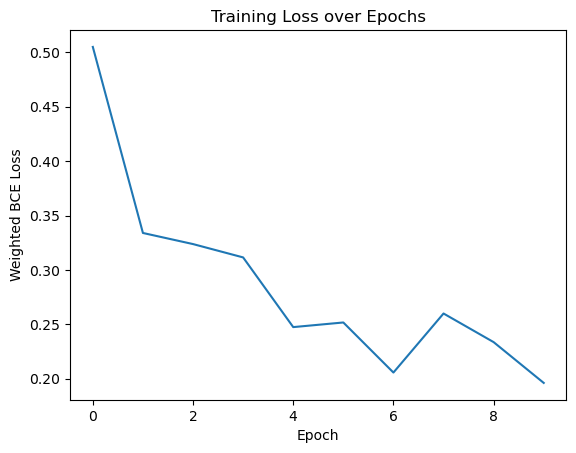

In [7]:
# ==========================================
# 5. Evaluation
# ==========================================

model.eval()
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        
        # Get raw logits
        logits = model(inputs)
        
        # Apply Sigmoid to get probabilities between 0 and 1
        probs = torch.sigmoid(logits)
        
        # Move to CPU for metrics
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())
        
        # Convert probabilities to binary predictions (Threshold 0.5)
        preds = (probs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())

# Calculate ROC-AUC 
roc_auc = roc_auc_score(y_true, y_scores)
print(f"\n--- Results ---")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Legit', 'Fraud']))

# Optional: Plot Loss
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Weighted BCE Loss')
plt.show()